<a href="https://colab.research.google.com/github/ishaqmarashy/Housing-Prices-ML/blob/main/Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [397]:
# Common imports
import requests
import pandas as pd
import numpy as np
import sklearn

# Plotting
%matplotlib inline
import io
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [398]:
raw_train_url = "https://raw.githubusercontent.com/ishaqmarashy/Housing-Prices-ML/main/train.csv"
raw_test_url = "https://raw.githubusercontent.com/ishaqmarashy/Housing-Prices-ML/main/test.csv"
def load_data(url):
  # download the csv file from github
  download = requests.get(url).content
  # read the downloaded content and put into dataframe
  df = pd.read_csv(io.StringIO(download.decode("utf-8")),index_col=0,infer_datetime_format=True,dayfirst=False)
  return df

In [399]:
train_df = load_data(raw_train_url)
test_df = load_data(raw_test_url)
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [400]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


# Some data is missing but we only require age from the missing values
# Drop the irrelevant data 'Name','Cabin','Ticket','Embarked'
def process(df):
  imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  df=pd.DataFrame(imp.fit_transform(df),columns=df.columns,index=df.index)
  # We know age and sex played an important role in the survival of the sinking titanic
  # We can use that to engineer a new feature
  return df
train_df=process(train_df)
test_df=process(test_df)
train_df.info() 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   MSZoning       1460 non-null   object
 2   LotFrontage    1460 non-null   object
 3   LotArea        1460 non-null   object
 4   Street         1460 non-null   object
 5   Alley          1460 non-null   object
 6   LotShape       1460 non-null   object
 7   LandContour    1460 non-null   object
 8   Utilities      1460 non-null   object
 9   LotConfig      1460 non-null   object
 10  LandSlope      1460 non-null   object
 11  Neighborhood   1460 non-null   object
 12  Condition1     1460 non-null   object
 13  Condition2     1460 non-null   object
 14  BldgType       1460 non-null   object
 15  HouseStyle     1460 non-null   object
 16  OverallQual    1460 non-null   object
 17  OverallCond    1460 non-null   object
 18  YearBuilt      1460 non-null

In [401]:
from sklearn.preprocessing import OneHotEncoder
for i in train_df:
  try :
    train_df[i]=train_df[i].astype(dtype='float32')
    test_df[i]=test_df[i].astype(dtype='float32')
  except :
      0
classCol=train_df.select_dtypes('object').columns
numCol=train_df.select_dtypes('float32').columns
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(pd.concat([train_df[classCol],test_df[classCol]]))

trans_train=pd.DataFrame(enc.transform(train_df[classCol]).toarray())
trans_test=pd.DataFrame(enc.transform(test_df[classCol]).toarray())
train_df.drop(columns=classCol, axis=1, inplace=True)
test_df.drop(columns=classCol, axis=1, inplace=True)

train_df=train_df.join(trans_train, on='BsmtFinSF2', how='left', lsuffix='_left', rsuffix='_right')
test_df=test_df.join(trans_test, on='BsmtFinSF2',how='left', lsuffix='_left', rsuffix='_right')


In [402]:
train_df[numCol].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.0000
mean,56.897259,68.267120,10516.828125,6.099315,5.575343,1971.267822,1984.865723,103.117126,443.639740,46.549316,...,94.244522,46.660275,21.954109,3.409589,15.060959,2.758904,43.489040,6.321918,2007.815796,180921.1875
std,42.300571,22.356356,9981.264648,1.382997,1.112799,30.202906,20.645407,180.731369,456.098083,161.319275,...,125.338799,66.256027,61.119152,29.317331,55.757412,40.177307,496.123016,2.703626,1.328095,79442.5000
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.0000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.0000
50%,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.0000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.0000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.0000


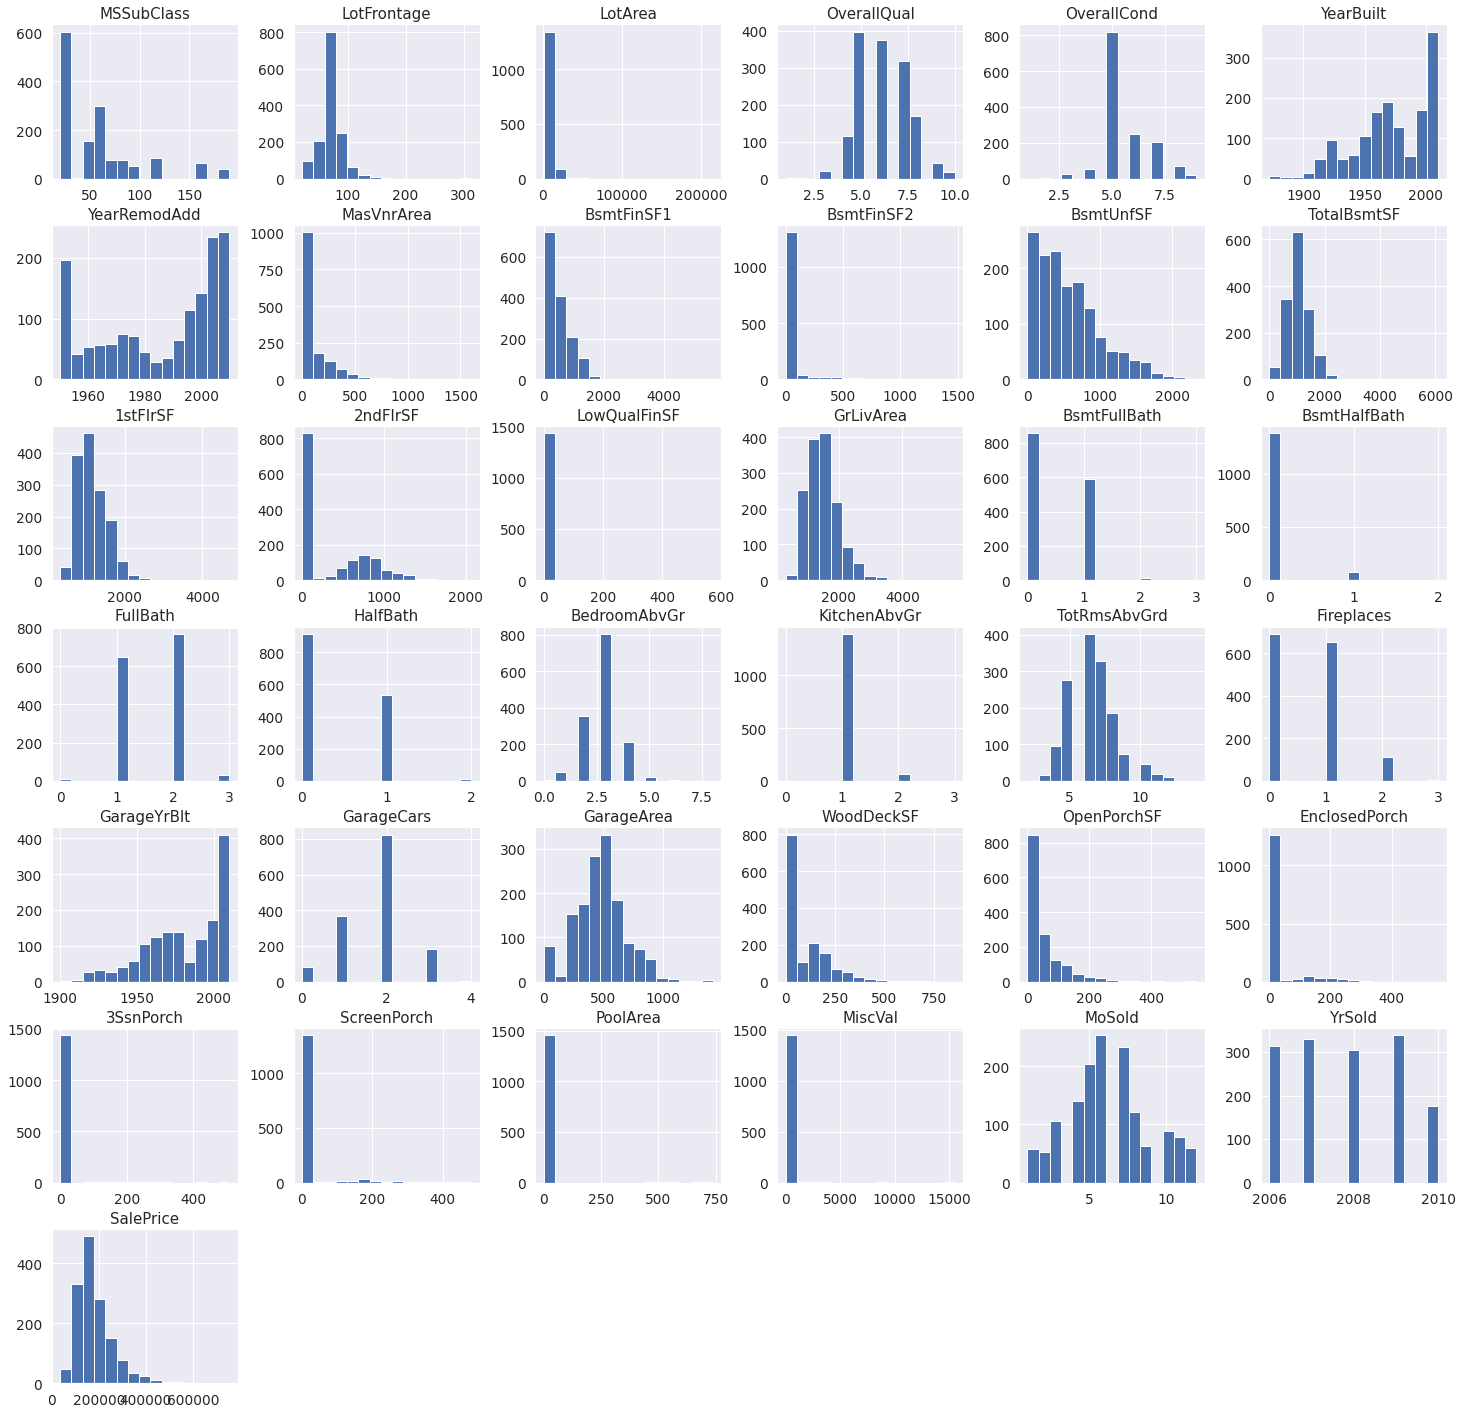

In [403]:
train_df[numCol].hist(bins=15, figsize=(25,25))
plt.show()

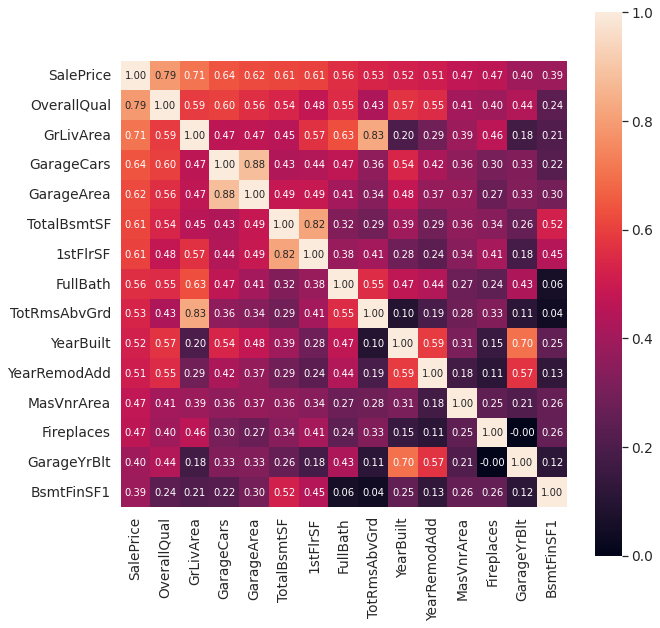

In [415]:
corrmat = train_df.corr()
plt.figure(figsize=(10,10))
columns = corrmat.nlargest(15, 'SalePrice')['SalePrice'].index
correlation_matrix = np.corrcoef(train_df[columns].values.T)
sns.set(font_scale=1.25)
heat_map = sns.heatmap(correlation_matrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
plt.show()

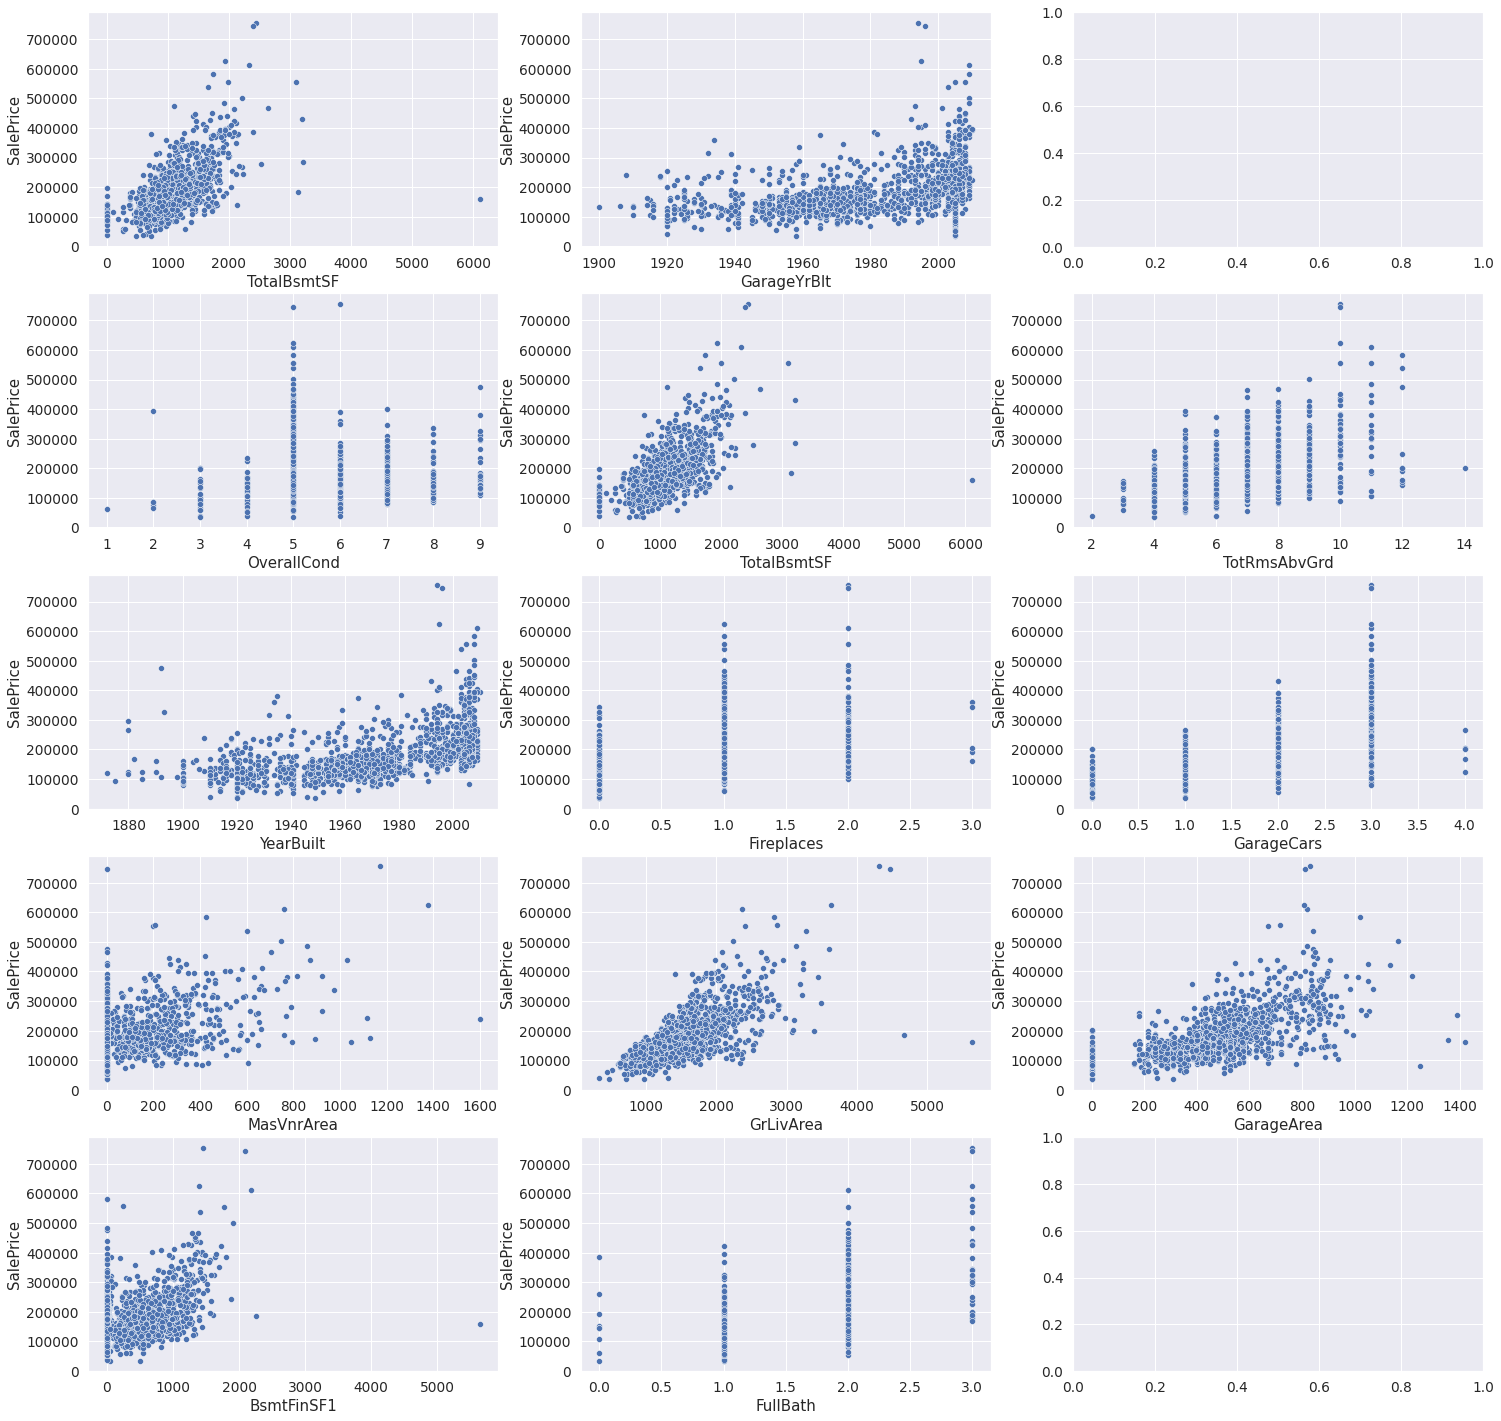

In [425]:
from pandas.plotting import scatter_matrix
plotted_features=['SalePrice','OverallCond','YearBuilt','MasVnrArea','BsmtFinSF1','TotalBsmtSF','TotalBsmtSF','Fireplaces','GrLivArea','FullBath','GarageYrBlt','TotRmsAbvGrd','GarageCars','GarageArea']
plotted_features.remove('SalePrice')
temp={}
c=0
k=5
j=0

fig5, axs = plt.subplots(k,3, figsize=(25, 25))
for i in plotted_features:
  if(c%k==0 and c!=0):
    j+=1
  c+=1  
  temp[i] = sns.scatterplot(x=train_df[i], y=train_df['SalePrice'],data=train_df, ax=axs[c%k,j])
plt.show()
plotted_features+=['SalePrice']

In [406]:
from sklearn.model_selection import train_test_split
X = train_df.drop("SalePrice", axis=1)
y = train_df["SalePrice"]
X_Pred=test_df
# 70% of the training data is being kept seperate to evaluate the model
# 30% goes in Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [407]:
X = train_df[plotted_features].drop("SalePrice", axis=1)

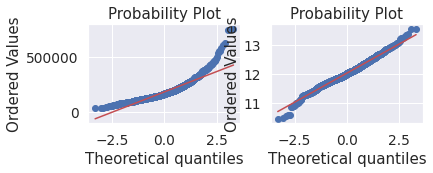

In [408]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 
fig = plt.figure()
ax = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
plt1 = stats.probplot(y, plot=ax)
plt2 = stats.probplot(np.log1p(y), plot=ax1)
plt.show()

In [427]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = make_pipeline(OneHotEncoder(handle_unknown='ignore'),LinearRegression())
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred=model.predict(X_test)
mae_pred_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train MAE: {mae_pred_train}')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Train MAE: 0.016485657570589618


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [410]:
# Metrics on how the data deals with the test set
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

1337150313.261707


In [411]:
y_pred_test=model.predict(X_Pred)
X_Pred['SalePrice']=y_pred_test
y_pred_test_df=X_Pred['SalePrice']
X_Pred=X_Pred.drop(columns=['SalePrice'])
#y_pred_test_df.to_csv('submission.csv', index=False)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
